In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score

import joblib
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import *
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestRegressor as RFr
from sklearn.preprocessing import StandardScaler

This notebook provides:

* scikit-learn based Random Forest regression for Multitemperature relaxation terms
* evaluation of zero-dimensional relaxation of O2-O mixture

Zero-dimensional relaxation problem can be described as:

\begin{equation}
    \begin{gathered}
     \frac{d n_{O2}}{dt} = R^{reac}_{O2} \\
    \frac{d n_O}{dt} = -2R^{reac}_{O2} \\
    \rho_{O2} \frac{d W}{d t} = R^w - m_{O2} W R^{reac}_{O2} \\
    \frac{d (\rho U)}{dt} = \frac{d}{d t}\left(\rho\left( E_{tr} + E_{rot} + E_{vibr} + E_f \right) \right) = 0
    \label{sis}
    \end{gathered}
\end{equation}

In [5]:
def mltpl(x, y):
  return np.dot(x, y)

In [6]:
tau = 4.640658158080029e-07
data_t_ = pd.read_csv('R_q/time_.csv', header=None, sep = ';', names=['T', 'T_Tv', 't'])
data_sRD_ = pd.read_csv('R_q/sRD.csv', header = None, sep = ';')
data_R_w_ = pd.read_csv('R_q/Rw.csv', header = None, sep = ';')
mask = data_t_['t'] <= 1/tau
data_t = data_t_[mask]
data_sRD = data_sRD_[mask]
data_R_w = data_R_w_[mask]


Zero-dimensional relaxation problem can be solved using multiple approximations. Here State-to-state and Multitemperature approximations are used:

* relaxation terms $R_{ci}$ in terms of state-to-state transport coefficients calculated according to the SSH theory.

* multitemperature relaxation terms $R_c$ via averaging of the state-to-state terms (at each solution step).

* multi-temperature relaxation terms $R_c$ obtained using the Random Forest algorithm.

Downloading precalculated **state-to-state** relaxation terms for chemical reactions ($R^{react}$) and energy exchange (VV: vibrational, VT: vibrational-transitional)

In [7]:
data_ = pd.read_csv('R_q/time_q.csv', header=None, sep = ';', names=['T', 'T_Tv', 't'])
data_RD = pd.read_csv('R_q/RD_q.csv', header = None, sep = ';')
data_RVV = pd.read_csv('R_q/RVV_q.csv', header = None, sep = ';')
data_RVT = pd.read_csv('R_q/RVT_q.csv', header = None, sep = ';')

In [8]:
data = np.loadtxt('R_q/time_q.csv', delimiter=';')
RD = np.array(data_RD)
RVV = np.array(data_RVV)
RVT = np.array(data_RVT)
tt = np.array(data_t)
sRD_ = np.array(data_sRD)
Rw_ = np.array(data_R_w)

Setting mixture parameters

In [9]:
e_i = np.loadtxt('R_q/e_i.csv', delimiter=';')
T0 = 15300
k = 1.3807e-23
ei_b = e_i/(k*T0)
lev = 26
nRD = int(RD.size/lev)

Transforming STS relax. terms to MT relax. terms according following equations:

\begin{equation}
    R_c^{2 \rightleftharpoons 3} = \sum_i R_{ci}^{2 \rightleftharpoons 3}
    \label{6}
\end{equation}

\begin{equation}
    R_c^{\text{W}} = \sum_i i ( R_{ci}^{2 \rightleftharpoons 3} + R_{ci}^{vibr})
    \label{7}
\end{equation}

In [10]:
ones_arr = np.ones(26)
ies = np.arange(0,26,1)
temp_RD = [np.sum(RD[i]) for i in range(nRD)]
RD_mt = np.array(temp_RD)
RVT_mt = RVT.dot(ies)
RVV_mt = RVV.dot(ies)
RDW_mt = RD.dot(ies)
RW = (RVT_mt + RDW_mt)

Checking that relaxation terms match:

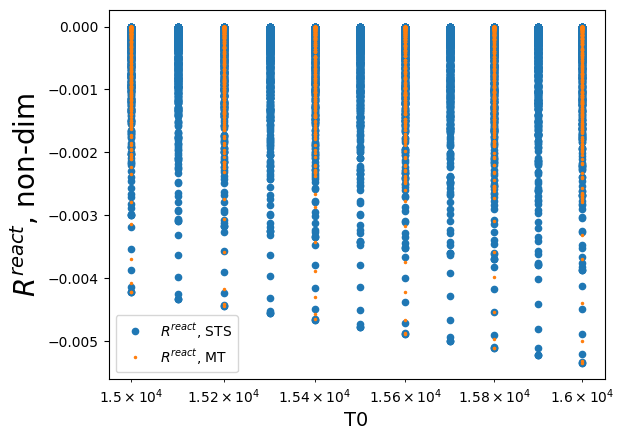

In [11]:
plt.plot(data[::12,0], RD_mt[::12], lw = 0.0, marker = '.', label='$R^{react}$, STS', markersize=9)
plt.plot(tt[::12,0], sRD_[::12], lw = 0.0, marker = '.', label='$R^{react}$, MT', markersize=3)

plt.xscale('log')
plt.xlabel('T0',  fontsize=14)
plt.ylabel('$R^{react}$, non-dim',  fontsize=20)
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
plt.legend(fontsize=10, loc='best')

plt.show()

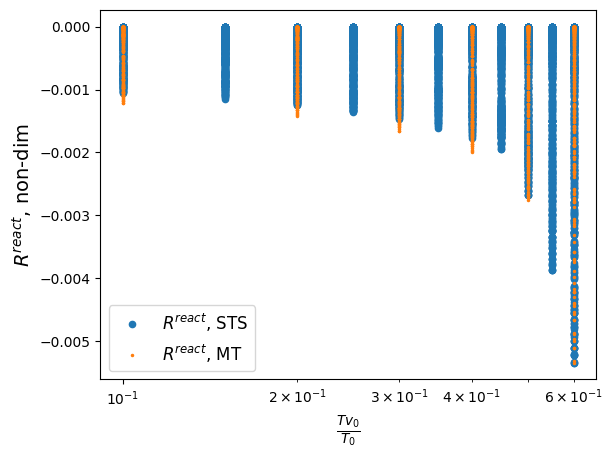

In [12]:
plt.plot(data[::12,1], RD_mt[::12], lw = 0.0, marker = '.', label='$R^{react}$, STS', markersize=9)
plt.plot(tt[::12,1], sRD_[::12], lw = 0.0, marker = '.', label='$R^{react}$, MT', markersize = 3)

plt.xscale('log')
plt.xlabel('$\\frac{Tv_0}{T_0}$', fontsize=14)
plt.ylabel('$R^{react}$, non-dim', fontsize=14)
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
plt.legend(fontsize=12)

plt.show()

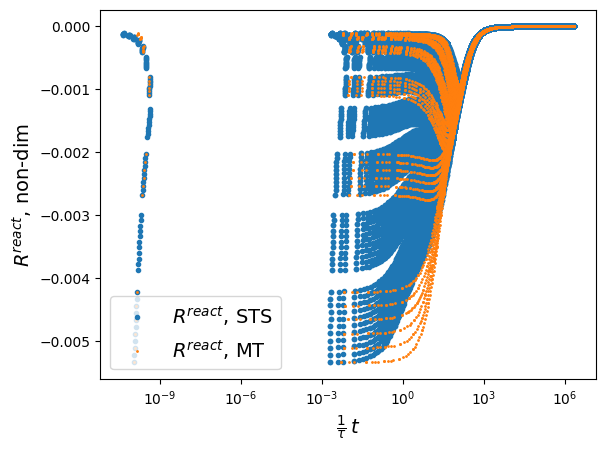

In [13]:
plt.plot(data[:,2], RD_mt, lw = 0.0, marker = '.', label='$R^{react}$, STS')
plt.plot(tt[:,2], sRD_, lw = 0.0, marker = '.', label='$R^{react}$, MT', markersize=2)

plt.xscale('log')
plt.xlabel('$\\frac{1}{\\tau} \, t$', fontsize = 14)
plt.ylabel('$R^{react}$, non-dim', fontsize=14)
plt.legend(fontsize = 14, loc='best')
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
plt.show()

In [14]:
step = 3

In [15]:
mask = [(data_['T'] == (15000 + i*100)) & (data_['T_Tv'] == 0.1) for i in range(0,11,step)]
lm = len(mask)
RD_arr = [np.array(data_RD[mask[i]]).dot(ones_arr) for i in range(lm)]
RW_arr =[ RW[mask[i]] for i in range(lm)]




In [16]:
t_arr = [np.array(data_[mask[i]]) for i in range(lm)]

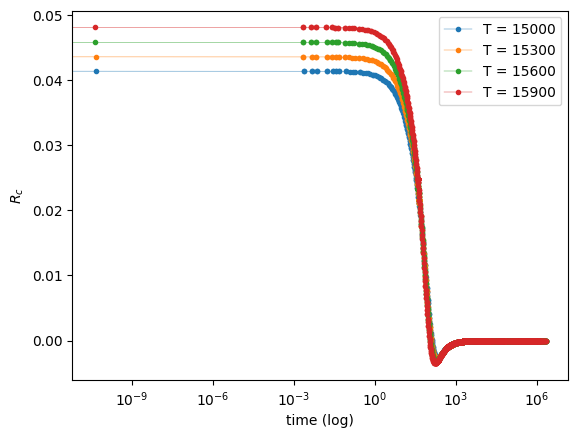

In [17]:
for i in range(lm):
  plt.plot(t_arr[i][:,2], RW_arr[i], lw = 0.3, label = f'T = {15000 + step*i*100}', marker='.')
plt.xscale('log')
plt.xlabel('time (log)')
plt.ylabel('$R_c$')
plt.legend()
plt.show()

In [18]:
mask = [(data_['T'] == 15000) & (data_['T_Tv'] == (0.1 + i*0.05)) for i in range(0,11,step)]
lm = len(mask)
RD_arr_ = [np.array(data_RD[mask[i]]).dot(ones_arr) for i in range(lm)]
RW_arr =[ RW[mask[i]] for i in range(lm)]
t_arr_ = [np.array(data_[mask[i]]) for i in range(lm)]

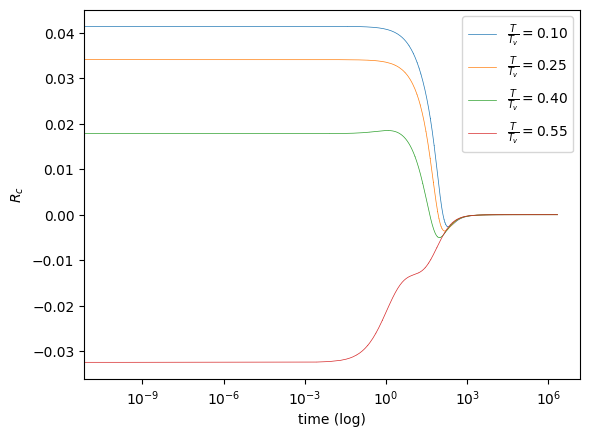

In [19]:
for i in range(lm):
  plt.plot(t_arr_[i][:,2], RW_arr[i], lw = 0.5, label = '$\\frac{T}{T_v} =$' + f'{0.1 + step*i*0.05:.2f}')
plt.xscale('log')
plt.xlabel('time (log)')
plt.ylabel('$R_c$')
plt.legend()
plt.show()

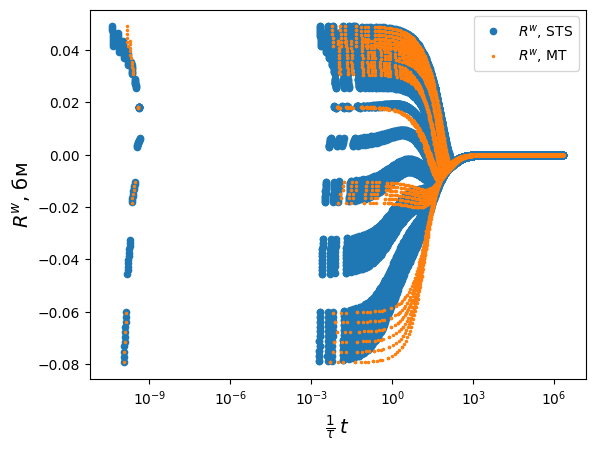

In [20]:
plt.plot(data[:,2], RW, lw = 0.0, marker = '.', label='$R^w$, STS', markersize=9)
plt.plot(tt[:,2], Rw_, lw = 0.0, marker = '.', label='$R^w$, MT', markersize=3)

plt.xscale('log')
plt.xlabel('$\\frac{1}{\\tau} \, t$', fontsize=14)
plt.ylabel('$R^w$, бм', fontsize=14)
plt.legend(fontsize=10)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
plt.show()

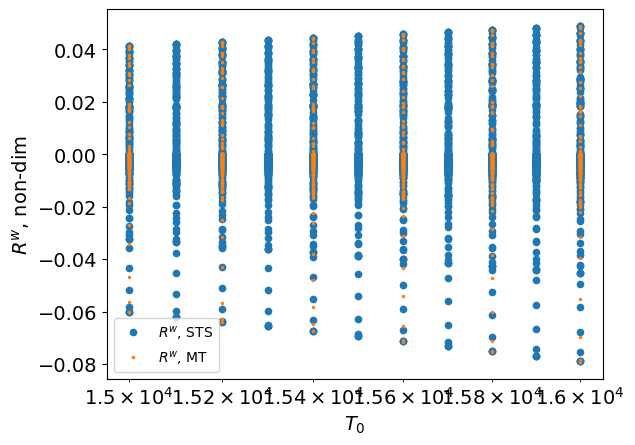

In [21]:
plt.plot(data[::12,0], RW[::12], lw = 0.0, marker = '.', label='$R^w$, STS', markersize=9)
plt.plot(tt[::12,0], Rw_[::12], lw = 0.0, marker = '.', label='$R^w$, MT', markersize=3)

plt.xscale('log')
plt.xlabel('$T_0$', fontsize=14)
plt.ylabel('$R^w$, non-dim', fontsize=14 )
plt.legend(fontsize=10)
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
plt.show()

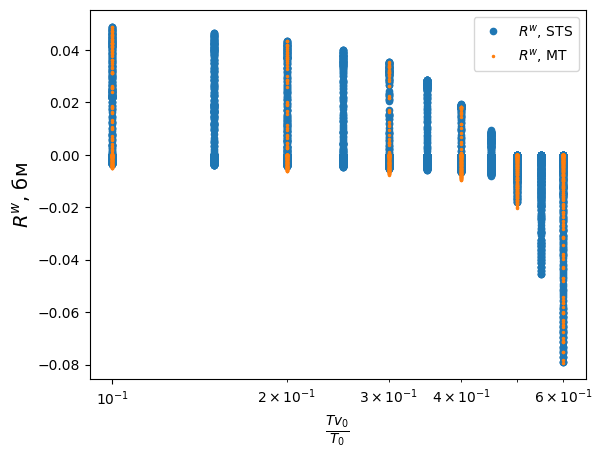

In [22]:
plt.plot(data[::12,1], RW[::12], lw = 0.0, marker = '.', label='$R^w$, STS', markersize=9)
plt.plot(tt[::12,1], Rw_[::12], lw = 0.0, marker = '.', label='$R^w$, MT', markersize=3)

plt.xscale('log')
plt.xlabel('$\\frac{Tv_0}{T_0}$', fontsize=14)
plt.ylabel('$R^w$, бм', fontsize=14)
plt.legend(fontsize=10)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
plt.show()

Training Random Forest

In [23]:
x = data_.copy()
y1 = RD_mt
y2 = RW

Using StandardScaler to normalize data

In [24]:
sclr_x = StandardScaler()
x = sclr_x.fit_transform(x)
sclr_y1 = StandardScaler()
y1 = sclr_y1.fit_transform(y1.reshape(-1,1)).ravel()
sclr_y2 = StandardScaler()
y2 = sclr_y2.fit_transform(y2.reshape(-1,1)).ravel()


In [25]:
x_train, x_test, y1_train, y1_test, y2_train, y2_test = train_test_split(x, y1, y2, train_size=0.25, test_size=0.75)

In [26]:
x_clf_, x_train_, y1_clf_, y1_train_,  y2_clf_, y2_train_ = train_test_split(x_train, y1_train, y2_train, train_size=0.05, test_size=0.95)

Finding the best Random Forest Regressor parameters (takes a lot of time, better use the cell under)

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RFr()
parameters = {'n_estimators':np.arange(50,81), 'max_depth':np.arange(11,41), 'max_leaf_nodes':np.arange(11,41)}
clf1 = GridSearchCV(rf, parameters)
clf1.fit(x_clf_, y1_clf_)
clf2 = GridSearchCV(rf, parameters)
clf2.fit(x_clf_, y2_clf_)
rf1 = clf1.best_estimator_
rf2 = clf2.best_estimator_



OR precalculated params:

In [32]:
rf1 = RFr(n_estimators=10, max_depth=14)
rf2 = RFr(n_estimators=80, max_depth=40)

In [33]:
rf1.fit(x_train_, y1_train_)

rf2.fit(x_train_, y2_train_)


RandomForestRegressor(max_depth=40, n_estimators=80)

Setting mixture parameters for the solver

In [34]:
c = 2.99e8
h = 6.6261e-34
k = 1.3807e-23
N_a = 6.0221e23
h_bar = h/(2*np.pi)

R = 8.3145;
l = 26
T0 = 15300
T_Tv = 0.3
Tv0 = 15300*T_Tv
xc = [1,0]
D = 59500
ef = np.array([0, k*0.5*D])
tau = 4.640658158080029e-07
e_0 = 1.565339295370500e-20

ef_b = ef/(k*T0);

# molecular vibrational energy, dimensionless
ei_b = e_i/(k*T0);

mm = 32*1e-3/N_a;
m = [mm, 0.5*mm]

In [40]:
Zv0 = np.sum(np.exp(-e_i/k/Tv0))

#non-dimensional params
Y0_bar = np.zeros(l+2);

#vibr. levels population (non-dim)
Y0_bar[:l] = xc[0]/Zv0*np.exp(-e_i/Tv0/k);

#initial amount of atoms
Y0_bar[l] = xc[1];

#temperature
Y0_bar[l+1] = 1;

In [41]:

E = 1/Zv0/mm*np.sum(e_i*np.exp(-e_i/Tv0/k))

#параметры в безразм. виде
Y0 = np.zeros(4);

#заселенности кол. уровней
Y0[0] = 1.0;

#нач. кол-во атомов
Y0[1] = 0.0;

#температура
Y0[2] = 1;

#W_c

Y0[3] = Tv0/T0;

In [42]:
ode15 = ode(pend)
ode15.set_integrator('vode', method='bdf', order=15)
ode15.set_initial_value(Y0, 0)
t_fin = 1/tau
times = [0]
sol = [Y0]
dt=t_fin/1000000
while ode15.successful() and ode15.t <= t_fin:
  ode15.integrate(t_fin, step=True)
  times.append(ode15.t)
  sol.append(ode15.y)

In [43]:
lev = np.arange(0,26,1)

In [37]:
import time
def pend(t, y):
    #n_c, n_a, T_b, E_b = y
    n_c, n_a, T_b, Tv_b = y

    xes = sclr_x.transform([[T0, T_Tv, t]])
    RD_b = sclr_y1.inverse_transform(rf1.predict(xes).reshape(-1,1))[0][0]

    RW_b = sclr_y2.inverse_transform(rf2.predict(xes).reshape(-1,1))[0][0]
    dnm = RD_b
    dna = -2*RD_b
    dnall = dnm+dna

    na_b = n_a
    nm_b = n_c

    e0_b = e_0/k/T0



    expB = np.exp(-e_i/(k*Tv_b*T0))
    Zv = np.sum(expB)


    j = e_i / (k*Tv_b*T0)

    dnitv = nm_b / Zv**2 * (Zv*j*expB/Tv_b - expB*j.dot(expB)/Tv_b)
    A = np.zeros((2,2))
    B = np.zeros(2)

    A[0][0] = 2.5*nm_b + 1.5*na_b
    A[0][1] = (ei_b+e0_b).dot(dnitv)

    B[0] = -dnm*(2.5*T_b+(ei_b+e0_b).dot(expB)/Zv) - dna*(1.5*T_b+ef_b[1])


    A[1][0] = 0
    A[1][1] = (Zv*np.sum(lev*j*expB/Tv_b) - lev.dot(expB)*j.dot(expB)/Tv_b)/Zv**2

    B[1] = (RW_b-RD_b*lev.dot(expB)/Zv)/nm_b



    x = np.linalg.solve(A, B)


    dT = x[0]
    dT_v = x[1]

    #dT = -(1.5*T_b*dnall+T_b*dnm + np.sum(ef_b*[dnm, dna]))/(2.5*n_c+1.5*n_a)
    #dE = (1.5*RW_b - E_b*RD_b)/(n_c)
    dydt = [dnm, dna, dT, dT_v]
    #time.sleep(300000000)
    return dydt

Integrating relaxation problem equations using BDF-method

In [38]:
import warnings
warnings.filterwarnings("ignore")

from scipy.integrate import ode

Precalculated solution of zero-dimensional relaxation problem using MT and STS approximation

In [56]:
x_mt = pd.read_csv('data/x.csv', header = None, sep = ';')
y_mt = pd.read_csv('data/y.csv', header = None, sep = ';')
x_sts = pd.read_csv('R_q/x_sts.csv', header = None, sep = ';')
y_sts = pd.read_csv('R_q/y_sts.csv', header = None, sep = ';')

In [52]:
Tv_sts = pd.read_csv('data/Tv_sts.csv', header = None, sep = ';')

Comparison of the precalculated MT and STS solution and the resulting mixed (STS+RF) approach solution

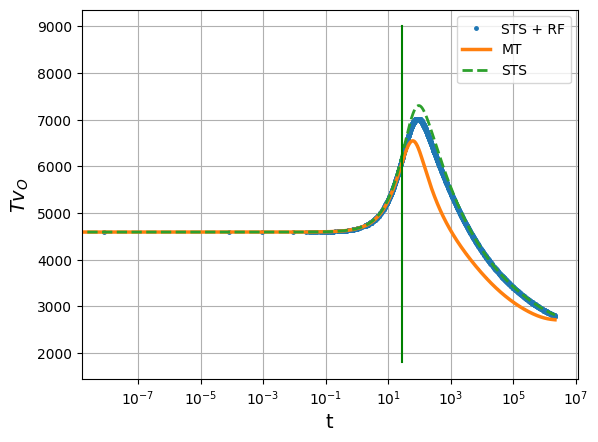

In [58]:
solut = np.array(sol)
x = 1/tau/80000
x_row = [x, x]
y_row = [1800, 9000]
plt.plot(times, solut[:,3]*T0, lw=0.0, marker='.', markersize=5,  label='STS + RF')
plt.plot(x_mt, y_mt[3]*T0, lw=2.5, marker=',', label='MT')
plt.plot(x_sts, Tv_sts, lw=2, linestyle='dashed', label='STS')

plt.plot(x_row, y_row, c = 'green')
plt.xlabel('t', fontsize=14)
plt.ylabel('$Tv_{O}$', fontsize=14)
plt.legend(loc='best', fontsize=10)
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
plt.xscale('log')
plt.grid()
plt.show()

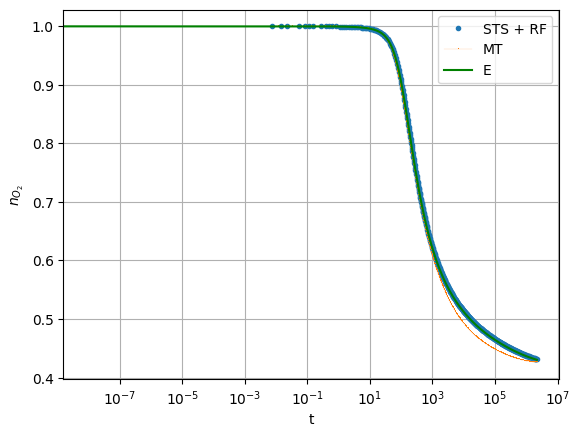

In [64]:

temp = np.array(y_sts).T
n = np.sum(temp[:26], axis=0)
plt.plot(x_sts, n, lw=0.0, marker='.', label='STS + RF')
plt.plot(x_mt, y_mt[0], lw=0.1, marker=',', label='MT')
plt.plot(times, solut[:, 0], 'g', label='E')
plt.xlabel('t')
plt.ylabel('$n_{O_2}$')
plt.legend(loc='best')
plt.xscale('log')
plt.grid()
plt.show()

Calculating $n_O2, i$ for MT according to Boltzman distribution 

In [74]:
n_ci = np.zeros((26, x_mt.shape[0]))
for i in range(26):
  for j in range(x_mt.shape[0]):
    expB = np.exp(-e_i/(k*y_mt[3][j]*T0))
    #expB = np.exp(-e_i/(k*0.3*T0))
    Zv = np.sum(expB)
    n_ci[i][j] = y_mt[0][j]*expB[i]/Zv



In [ ]:
plt.hist(n_ci[0], bins='auto')
plt.show()

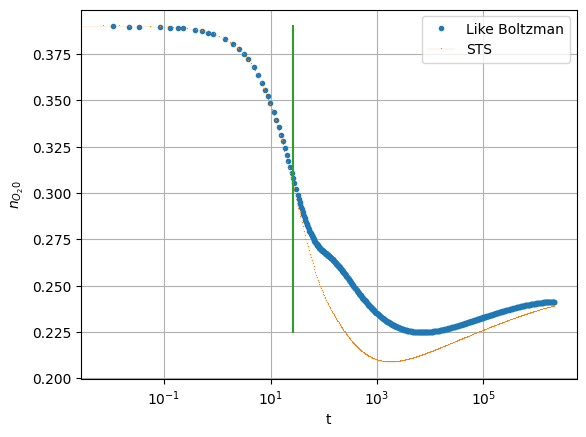

In [79]:
plt.plot(x_mt, n_ci[0], lw=0.0, marker='.', label='Boltzman')
plt.plot(x_sts, y_sts[0], lw=0.1, marker=',', label='STS')
plt.plot(x_row, [np.min(n_ci[0]), np.max(n_ci[0])])
plt.xlabel('t')
plt.ylabel('$n_{O_2 0}$')
plt.legend(loc='best')
plt.xscale('log')
plt.grid()
plt.show()

In [86]:
 plt.rcParams["figure.figsize"] = (20,12)

In [84]:
def point(a, b, time):
  index = np.argmin(abs(a - time))
  if index >= 499:
    index = index - 1
  res = (b[index][:26] + b[index+1][:26])/2
  return res

lent = x_mt.shape[0]
x_sts_t = np.array(x_sts[0])
x_mt_t = np.array(x_mt[0])
yyy = np.array(y_sts)

n_ci_sts = np.zeros((lent,26))
for i in range(lent):
  n_ci_sts[i] = point(x_sts_t, yyy, x_mt_t[i])

In [100]:
import sklearn.preprocessing

Comparing distributions of vibrational level populations for MT and STS

In [199]:
a = n_ci.flat
b = n_ci_sts .flat
n_ci_ = sklearn.preprocessing.scale(a)
n_ci_sts_ = sklearn.preprocessing.scale(b)

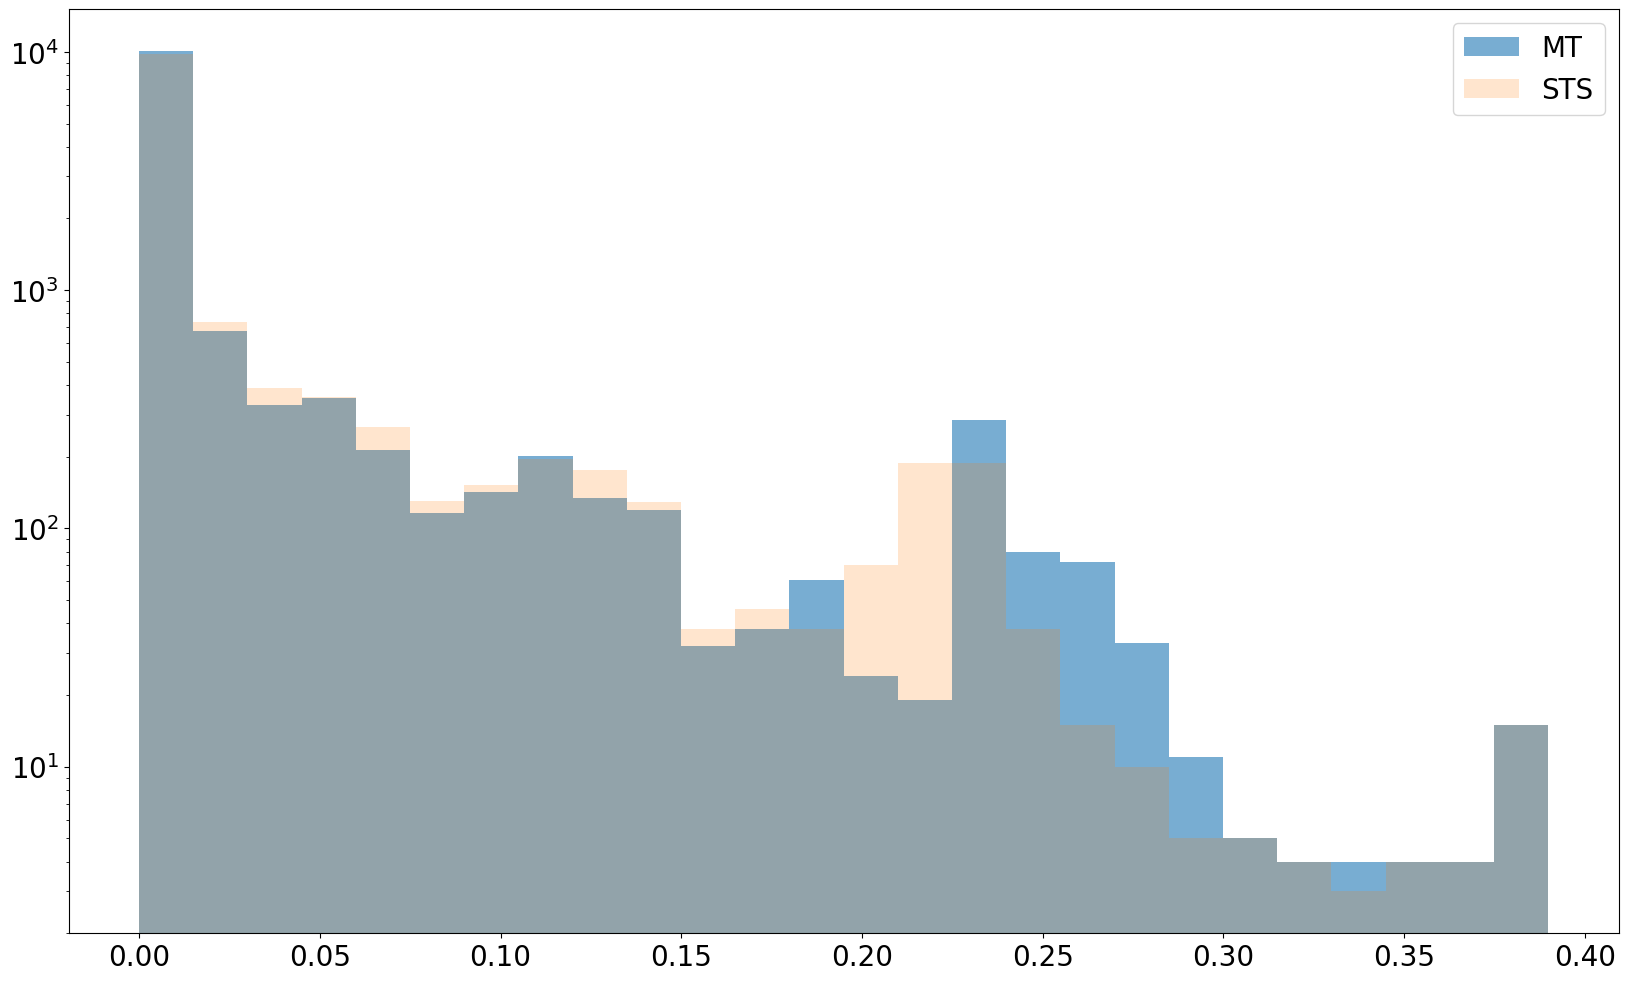

In [200]:
plt.hist(n_ci_, 26, histtype='bar', alpha = 0.6, stacked=True, label='MT')
plt.hist(n_ci_sts_, 26, histtype='bar', alpha = 0.2, stacked=True, label='STS')
plt.yscale('log')
plt.legend(fontsize="20")
plt.show()

In [82]:
# Mixture density
p0=2*133.332
n0 = p0/k/T0
n_m = solut[:,0]*n0
n_a=solut[:,1]*n0
Temp = solut[:,-2]*T0
Nall = n_a+n_m
m=np.array(m)
rho = m.dot(np.array([n_m, n_a]))
Tv_ = solut[:,-1]*T0

# Pressure
p = k*Nall.dot(Temp)

expB = [np.exp(-np.power(k*Tv_, -1)*( el)) for el in e_i  ]
#np.exp(-np.power(k*Tv_, -1)*( e_i))
Zv = np.sum(np.array(expB), axis = 0)

n_i = [(n_m / Zv) * expB[i] for i in range(26)]
n_i = np.array(n_i)

# Vibrational energy
ev_i = (e_i+e_0)*(n_i.T)

#ev_i = np.array([(e_i+e_0)*(n_i[:, i]) for i in range(26)])
e_v = np.sum(ev_i, axis=1)

# Formation energy
e_f_ = np.array([np.array([n_m, n_a]).dot(efl) for efl in ef])
e_f = np.sum(e_f_, axis=1);

#  Translational energy
e_tr = 1.5*k*Nall.dot(Temp)

# Rotational energy
e_rot = k*n_m.dot(Temp)

# Total energy
E = e_tr+e_rot+e_v+e_f

rho0 = rho[0]
E0 = E[0]

# Absolute Residual
u1 = rho0-rho
u2 = E0-E

# Relative Residual
d1 = (np.abs(u1)/rho0).max()
d2 = (np.abs(u2)/E0).max()

print(d1)
print(d2)

7.273561879074183e-15
0.0003699768751927986


Checking that $n_{O2} + n_O = 1$

In [72]:
print((solut[:,1]/2 + solut[:,0]).mean())

0.9999999999999953
